# DPC figure
> Georgios Varnavides*, Stephanie Ribet* et al.  
> 05/20/2024

This notebook reproduces the differential phase contrast figure (Fig. 2) in the manuscript [Iterative Phase Retrieval Algorithms for Scanning Transmission Electron Microscopy](https://arxiv.org/abs/2309.05250).

## Imports

In [1]:
import ase 
import abtem
import py4DSTEM
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from scipy.ndimage import zoom,gaussian_filter, rotate

import cmasher as cmr

## abTEM Simulations

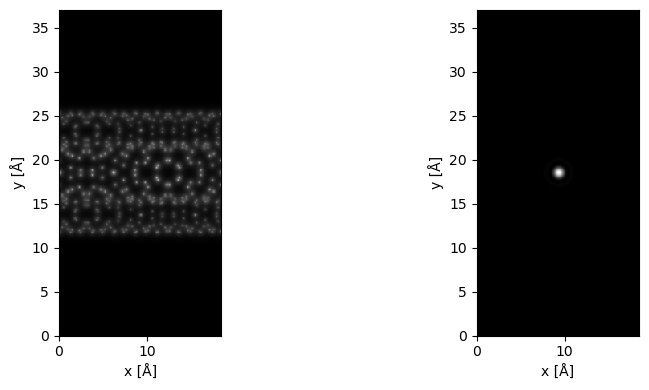

In [3]:
outer_cnt = ase.build.nanotube(12, 8, length=1)
inner_cnt = ase.build.nanotube(6, 4, length=1)
double_walled_cnt = outer_cnt + inner_cnt
double_walled_cnt.center(vacuum=0, axis=(0,1))
padding = double_walled_cnt.cell[2,2] - double_walled_cnt.cell[0,0]/2
double_walled_cnt.center(vacuum=padding, axis=(0,1))

# double_walled_cnt.rotate('x', 'z', rotate_cell=True)
# manual rotation
positions = double_walled_cnt.positions
positions_new = positions.copy()
positions_new[:,0] = positions[:,2]
positions_new[:,2] = positions[:,0]

double_walled_cnt = ase.Atoms(
    double_walled_cnt.symbols,
    positions = positions_new,
    cell=np.array([
        double_walled_cnt.cell[2,2],
        double_walled_cnt.cell[1,1],
        double_walled_cnt.cell[0,0]
    ])
)

double_walled_cnt_center = double_walled_cnt.cell.lengths()/2

frozen_phonons = abtem.temperature.FrozenPhonons(double_walled_cnt, 12, 0.075)

static_potential = abtem.Potential(
    #frozen_phonons,  # uncomment this for a realistic simulation     
    double_walled_cnt, # comment this for a realistic simulation
    gpts=(int(96*3*np.sqrt(2)/2),int(96*3*np.sqrt(2))),
    device="gpu",
    projection="infinite",
    parametrization="kirkland",
)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(10,4))

static_potential.project().show(ax=ax1)
probe = abtem.Probe(semiangle_cutoff=25, energy=80e3, defocus=0,device="gpu")
probe.match_grid(static_potential)
probe.show(ax=ax2)

fig.tight_layout();

In [5]:
pixelated_detector = abtem.PixelatedDetector(max_angle=None)

grid_scan = abtem.GridScan(
    (0, static_potential.extent[1]/2-static_potential.extent[0]/2), (static_potential.extent[0],static_potential.extent[1]/2+static_potential.extent[0]/2),
    gpts=(73,73),
    endpoint=True
)

measurement = probe.scan(grid_scan, pixelated_detector, static_potential)
sx,sy,qx,qy = measurement.shape
crop_qx = (qx - 96)//2
crop_qy = (qy - 96*2)//2

array = measurement.array[:,:,crop_qx:crop_qx+96,crop_qy:crop_qy+96*2]
array = array.reshape((sx,sy,96,96,2)).sum(-1)

# rotate and transpose
array = rotate(array,angle = 17, axes=(-2,-1),order=1,reshape=False).swapaxes(-2,-1)

np.random.seed(1234)
electrons_per_area = 1e5
electrons_per_probe = electrons_per_area*np.array(grid_scan.sampling).prod()
noisy_array = np.random.poisson(array*electrons_per_probe).astype(np.uint16)

Potential:   0%|          | 0/75 [00:00<?, ?it/s]

Scan:   0%|          | 0/5329 [00:00<?, ?it/s]

In [6]:
dc = py4DSTEM.DataCube(noisy_array)

dc.calibration.set_R_pixel_size(measurement.calibrations[0].sampling)
dc.calibration.set_R_pixel_units('A')
dc.calibration.set_Q_pixel_size(measurement.calibrations[2].sampling)
dc.calibration.set_Q_pixel_units('mrad')
dc.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:    2.248767617895552
             R_pixel_size:    0.2579015208261565
             Q_pixel_units:   mrad
             R_pixel_units:   A
             QR_flip:         False
)

## DPC Reconstructions

Best fit rotation = -17 degrees.
Diffraction intensities should be transposed.


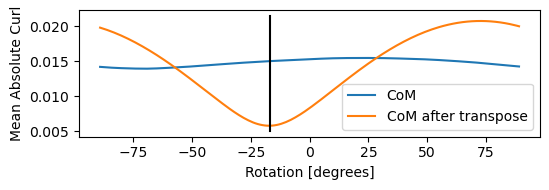

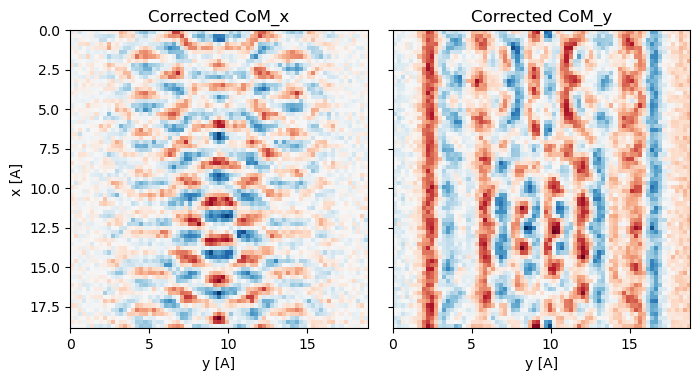

In [7]:
dpc = py4DSTEM.process.phase.DPC(
    datacube=dc, 
    energy = 80e3, 
    device = "cpu"
).preprocess(
)

Reconstructing phase:  42%|▍| 27/64 [00:00<00:00, 484
Step-size has decreased below stopping criterion 1e-06.


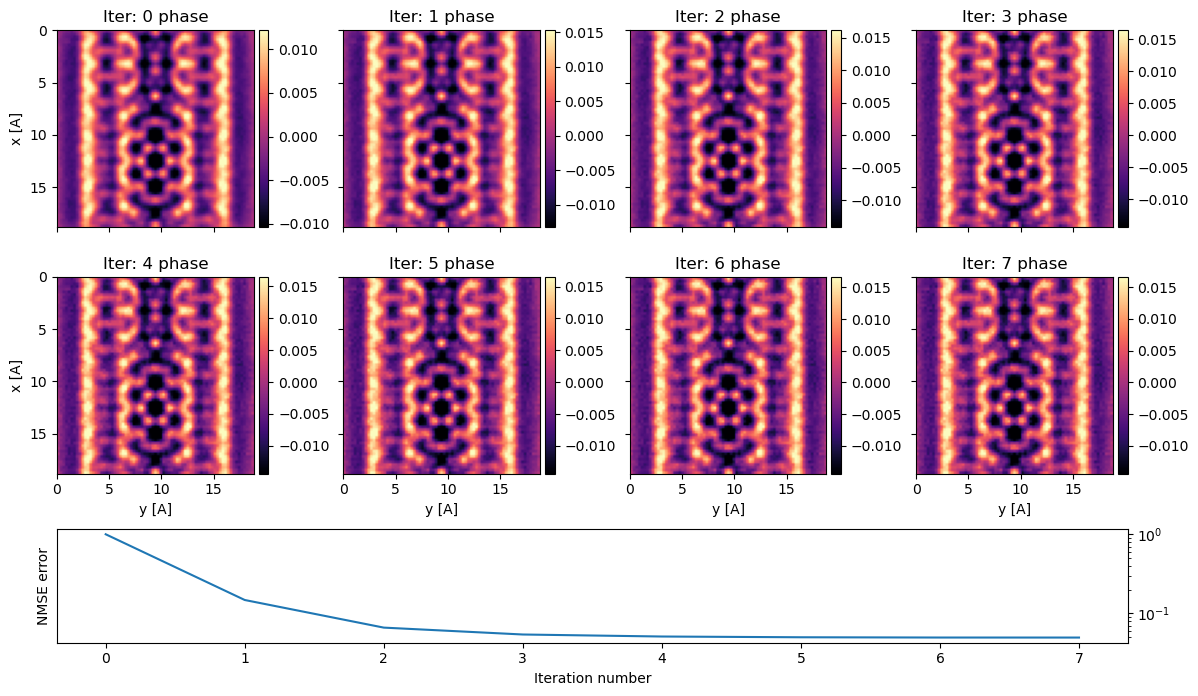

In [8]:
dpc=dpc.reconstruct(
    store_iterations = True, 
    reset = True, 
).visualize(
    iterations_grid = "auto"
)

## Visualization

In [28]:
dc.get_dp_mean()
r, _, _  = dc.get_probe_size()

dc.get_virtual_image(
    mode = "annular", 
    geometry = ((0,0), (r * 2, 100)), 
    centered = True, 
    name = "DF"
)

100%|█████████| 5329/5329 [00:00<00:00, 82055.88it/s]


VirtualImage( A 2-dimensional array of shape (73, 73) called 'DF',
              with dimensions:

                  dim0 = [0,1,2,...] pixels
                  dim1 = [0,1,2,...] pixels
)

In [29]:
#inputs
im_size = (200,200)
p = np.zeros(im_size)
a = np.ones(im_size)
pixel_size = 0.6

x = (np.arange(im_size[0]) - im_size[0]/2) * pixel_size 
y = (np.arange(im_size[1]) - im_size[1]/2) * pixel_size 

ya, xa = np.meshgrid(y,x)

p += (np.pi/4)*np.exp(((xa-0)**2 + (ya-0)**2)/(-2 * 0.6 ** 2))

t = a*np.exp(1j*p)

k_probe = 25/1000 / abtem.utils.energy2wavelength(80e3)

kx = np.fft.fftfreq(im_size[0], pixel_size)
ky = np.fft.fftfreq(im_size[1], pixel_size)
kya,kxa = np.meshgrid(ky,kx)
kra = (kya**2+kxa**2)**0.5
# ktheta = np.arctan2(kya,kxa)

#Psi = kra < k_max
dk = kx[1]-kx[0]
Psi_init = np.clip((k_probe - kra)/dk ,0 ,1)
psi_init = np.fft.ifft2(Psi_init)


def scan_probe(
    Psi,
    kxa,
    kya,
    r_shift, 
    ): 
    '''
    Function for applying shift operator 
    Important: operator needs to be applied in reciprocal space 
    
    Inputs:
    Psi (array): initial probe 
    kxa (array): coordinate system x
    kya (array): coorindate system y 
    r_shift (tuple): shift in x and y 
    
    Returns:
    Psi_shift (array): shifted Psi 
    '''
    Psi_shift = Psi * np.exp(-2j*np.pi*(kxa*r_shift[0] + kya*r_shift[1]))
    
    return Psi_shift
    

r_shift = (60,60.4)
psi = np.fft.ifft2(scan_probe(Psi_init, kxa, kya, r_shift)) 
psi *= t
Psi = np.fft.fft2(psi)
Psi_meas = np.abs(Psi)**2

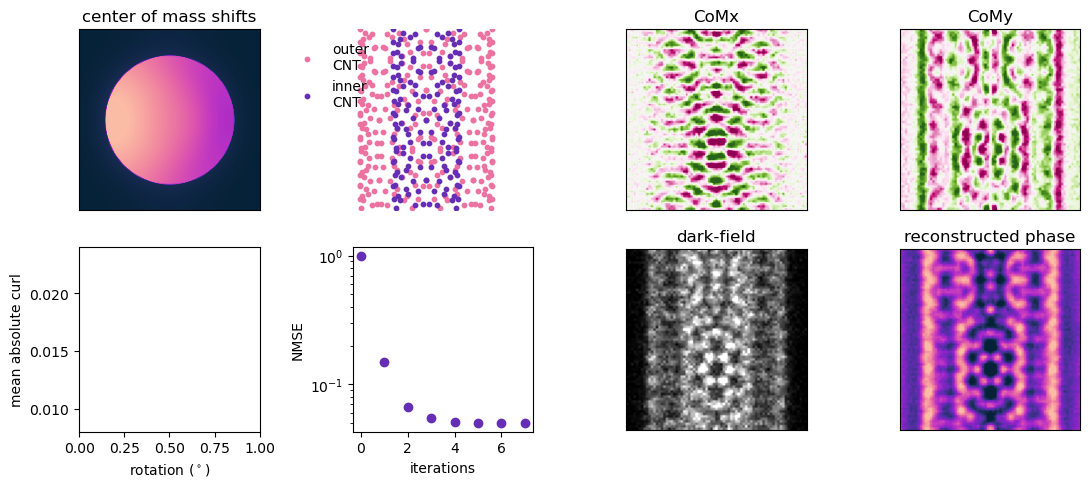

In [30]:
# plt.rcParams.update({'font.size': 11})

cmap = cmr.bubblegum

fig, ax = plt.subplots(2,4,figsize = (11,5))
outer_cnt = ase.build.nanotube(12, 8, length=1)
inner_cnt = ase.build.nanotube(6, 4, length=1)

ax[0,1].scatter(outer_cnt.positions[:,0]+10-outer_cnt.positions[:,0].min(),outer_cnt.positions[:,2], s = 10, color = "#EB72A1", label = "outer\nCNT")
ax[0,1].scatter(inner_cnt.positions[:,0]+10-outer_cnt.positions[:,0].min(),inner_cnt.positions[:,2], s = 10, color = '#662DB5', label = "inner\nCNT")
ax[0,1].set_aspect('equal')
ax[0,1].set_ylim([static_potential.extent[0],0])
ax[0,1].set_xlim([static_potential.extent[1]/2-static_potential.extent[0]/2,static_potential.extent[1]/2+static_potential.extent[0]/2])
ax[0,1].legend(frameon=False, loc='upper left', bbox_to_anchor=(-0.4, 1))

ax[0,1].axis('off')


py4DSTEM.show(
    dc.tree('DF').data, 
    figax = (fig, ax[1,2]), 
    ticks = False, 
    title = "dark-field", 
    # cmap = cmap
)

py4DSTEM.show(
    dpc._com_x, 
    figax = (fig, ax[0,2]), 
    ticks = False, 
    cmap ='PiYG', 
    title = "CoMx"
)

py4DSTEM.show(
    dpc._com_y, 
    figax = (fig, ax[0,3]), 
    ticks = False, 
    cmap = 'PiYG',
    title = "CoMy"
)


py4DSTEM.show(
    np.fft.fftshift(
        Psi_meas
    ), 
    cmap = cmap, 
    figax = (fig, ax[0,0]), 
    ticks = False, 
    title = "center of mass shifts", 
)


# ax[1,0].plot(DPC._rotation_angles_deg, DPC._rotation_curl, color = "#EB72A1", label = "not transposed")
# ax[1,0].plot(DPC._rotation_angles_deg, DPC._rotation_curl_transpose, color = '#662DB5', label = "transposed")
ax[1,0].set_ylabel('mean absolute curl')
ax[1,0].set_xlabel('rotation ($^\circ$)')
ax[1,0].set_ylim([0.008,0.024])
# ax[1,0].set_yticks([])


py4DSTEM.show(
    dpc.object_phase, 
    figax = (fig, ax[1,3]), 
    ticks = False, 
    title = "reconstructed phase", 
    cmap = cmap
)
            
ax[1,1].scatter(np.arange(len(dpc.error_iterations)), dpc.error_iterations, color = "#662DB5")
ax[1,1].set_ylabel('NMSE')
ax[1,1].set_xlabel('iterations')
ax[1,1].set_yscale('log')

fig.tight_layout()
# plt.savefig('fig_DPC.svg', dpi = 350, bbox_inches = "tight", pad_inches = 0.1)

## Postprocessing
> Done in Inkscape